In [2]:
# Import our ARIMA model 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.tsa.stattools as st

from arch import arch_model

# Import Numerical Analysis 
import scipy 
import seaborn as sns 
from sklearn.metrics import mean_squared_error
from math import sqrt

# Import Data analytics
import matplotlib.pyplot as plt 
import matplotlib.pyplot as plt 
from pandas import * 
from datetime import datetime
import pandas as pd
from pandas.plotting import autocorrelation_plot
import os

import warnings 
warnings.filterwarnings("ignore")
sns.set()

## tsplot 
- AutoCorrelationFunction

- Partial AutoCorrelation Function   

In [3]:
def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Original source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

## ARIMA_PLOT_KI ANALYISATION 
*HOW IT WORKS*
Function Definition: 
 Parameters; 
  - series: The time series data as a pandas series
  - order: A tuple of parameters (p, d, q) for ARIMA model where:
      - p: Number of lag observations included in the model
      - d: degree of differencing
      - q: Size of Moving average window
  - train_size_percent: Proportion of the dataset to be used as the 
                        training set.
  - scale: Scaling factor for the data visualization, set to 1 
           (default)

*DATA PREPROCESSING* 

When preprocessing our data we will want to convert the series into a dataframe. It will also name the single column as 'actual'

When it comes to handling duplicates, we will simply remove the index values while keeping the previous occurence. Instead of just removing null values - this can lead to inaccurate data - the code will resample the data to daily frequency, filling missing dates using forward fill which carries the last known value forward. 

*TRAIN/TEST SPLIT* 

"train_size_percent" will calculate the size of training set. It will identify the starting index of the test set. 

*ERROR CALCULATION*

Using Mean Squared Error (MSE) we can calculate the MSE between the actual values and predictions to quantify the forecasting error. 

*DATA SCALING & PLOTTING* 
When scaling data, we want to make sure that it correctly fits the grapg. We do this by dividing the actual and predicted values by the scale parameter to fit. 

In [4]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [5]:
def AIC_BIC_HQIC(series, max_ar = 4, max_ma= 4):
    train_results = sm.tsa.arma_order_select_ic(series, ic=['aic', 'bic', 'hqic'], trend='n', max_ar=max_ar, max_ma=max_ma)

    print('AIC', train_results.aic_min_order)
    print('BIC', train_results.bic_min_order)
    print('HQIC', train_results.hqic_min_order)

In [6]:
def adf(series):
    adf_result = st.adfuller(series, store = True)
    print("ADF Test Results: ")
    print("Test Statistic: %.4f" % adf_result[0])
    print("p-value: %.10f" % adf_result[1])
    print("Critical Values: ")
    for key, value in adf_result[2].items():
        print('\t%s: %0.3f' % (key, value))

In [7]:
def kpss(series):
    kpss_result = st.kpss(series, store=True)
    print("KPSS Test Results: ")
    print("Test Statistic: %.4f" % kpss_result[0])
    print("p-value: %.10f" % kpss_result[1])
    print("Critical Values: ")
    for key, value in kpss_result[2].items():
        print('\t%s: %0.3f' % (key, value))

In [8]:
# Stock to be used 
# MSFT - Microsoft 
# AAPL - Apple
# AMZN - Amazon

# Get CSV file 
files = os.listdir('FinancialDatasets/stocks')
print("Files: ", files)

print("\n")
# Stock Data for Apple 
AAPL_File_Path = os.path.join('FinancialDatasets/stocks', 'AAPL.csv')
AAPLStock = pd.read_csv(AAPL_File_Path, header=0, index_col=0, parse_dates=True)

#Clean data and remove old data pror to 2022 
AAPLStock.index = pd.to_datetime(AAPLStock.index, utc=True)
AAPLStock = AAPLStock.drop(AAPLStock[AAPLStock.index < '2022'].index)

print("Apple Stock Data :\n", AAPLStock)
print("\n")

# Stock Data for Amazon 
AMZN_File_Path = os.path.join('FinancialDatasets/stocks', 'AMZN.csv')
AMZNStock = pd.read_csv(AMZN_File_Path, header=0, index_col=0, parse_dates=True)

AMZNStock.index = pd.to_datetime(AMZNStock.index, utc=True)
AMZNStock = AMZNStock.drop(AMZNStock[AMZNStock.index < '2022'].index)
print("Amazon Stock Data :\n", AMZNStock)


# Stock Data for Microsoft
MSFT_File_Path = os.path.join('FinancialDatasets/stocks', 'MSFT.csv')
MSFTStock = pd.read_csv(MSFT_File_Path, header = 0, index_col=0, parse_dates=True)
# Now we will convert the date column and drop all dates prior to 2022
MSFTStock.index = pd.to_datetime(MSFTStock.index, utc=True)
MSFTStock = MSFTStock.drop(MSFTStock[MSFTStock.index < '2022'].index)

print("Microsoft Data: ", MSFTStock)

# Using 3 csv files containing stock market data of Apple, Microsoft and Amazon
# Each dataset will be used to predict future prices using the AutoRegressive Integreated Moving Average Model. 

Files:  ['AAPL.csv', 'AMZN.csv', 'archive', 'MSFT.csv']


Apple Stock Data :
                                  Open        High         Low       Close  \
Date                                                                        
2022-01-03 05:00:00+00:00  176.052761  181.052294  175.933965  180.190979   
2022-01-04 05:00:00+00:00  180.804778  181.111677  177.329848  177.904053   
2022-01-05 05:00:00+00:00  177.814944  178.369344  172.894614  173.171814   
2022-01-06 05:00:00+00:00  170.973992  173.548013  169.924588  170.280991   
2022-01-07 05:00:00+00:00  171.162116  172.399623  169.320704  170.449310   
...                               ...         ...         ...         ...   
2023-09-15 04:00:00+00:00  176.479996  176.500000  173.820007  175.009995   
2023-09-18 04:00:00+00:00  176.479996  179.380005  176.169998  177.970001   
2023-09-19 04:00:00+00:00  177.520004  179.630005  177.130005  179.070007   
2023-09-20 04:00:00+00:00  179.259995  179.699997  175.399994  175.490005  

In [9]:
AAPLStock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 432 entries, 2022-01-03 05:00:00+00:00 to 2023-09-21 04:00:00+00:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          432 non-null    float64
 1   High          432 non-null    float64
 2   Low           432 non-null    float64
 3   Close         432 non-null    float64
 4   Volume        432 non-null    int64  
 5   Dividends     432 non-null    float64
 6   Stock Splits  432 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 27.0 KB


In [10]:
# Lets now create the dataframe (df) which will store our market data 
AAPLStock.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,432.000000,432.000000,432.000000,432.000000,4.320000e+02,432.000000,432.0
mean,159.586376,161.486107,157.823683,159.715909,7.675141e+07,0.003750,0.0
std,16.786926,16.526356,16.964941,16.723516,2.537321e+07,0.029265,0.0
min,125.474679,127.227186,123.642480,124.488869,2.759590e+07,0.000000,0.0
25%,146.597942,148.567263,144.551712,146.976749,5.772300e+07,0.000000,0.0
50%,159.032660,161.594645,157.163041,158.758820,7.338795e+07,0.000000,0.0
75%,172.200851,173.549822,170.602851,172.764484,8.953065e+07,0.000000,0.0
max,195.975362,197.962667,195.016650,196.185074,1.826020e+08,0.240000,0.0


## APPLE STOCK ANALYSIS W/FINANCIAL DATA


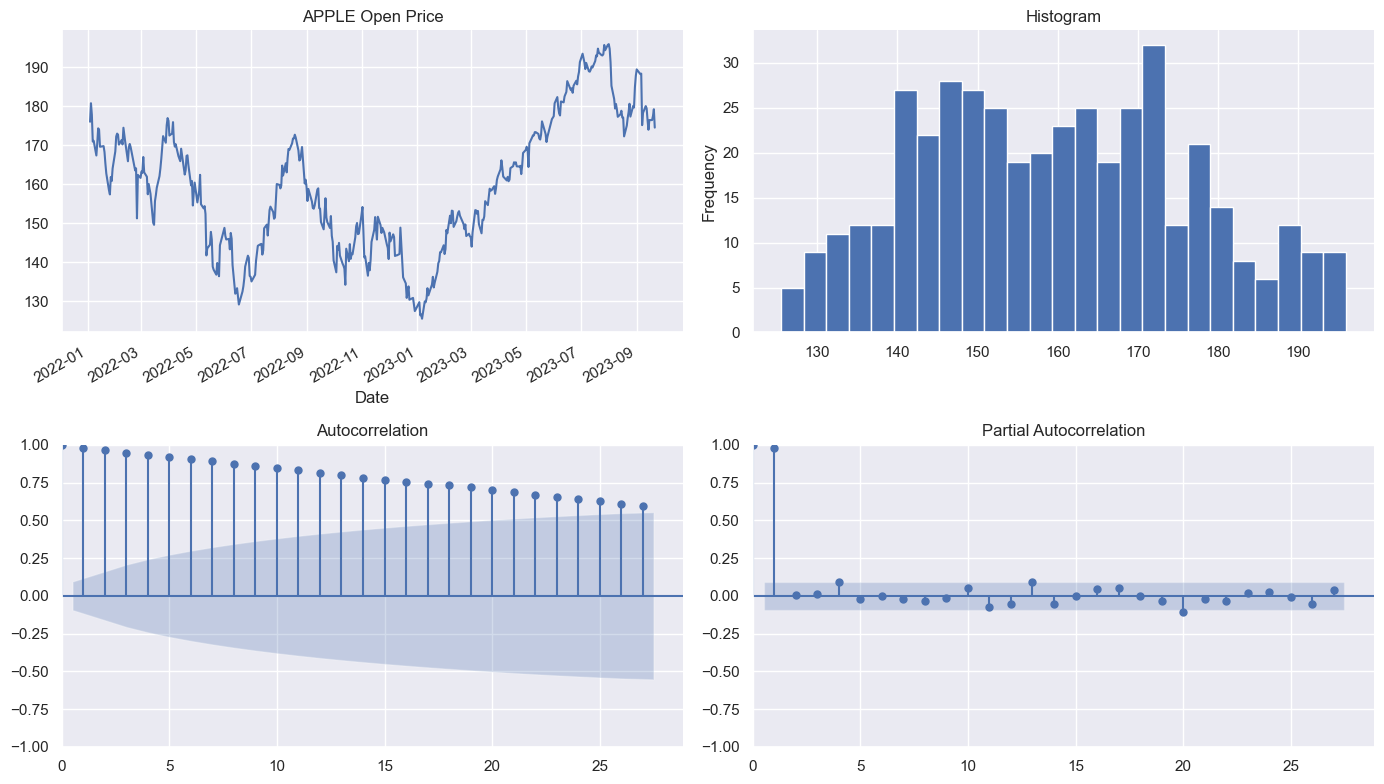

In [11]:
tsplot(AAPLStock['Open'], title = 'APPLE Open Price')
plt.show()

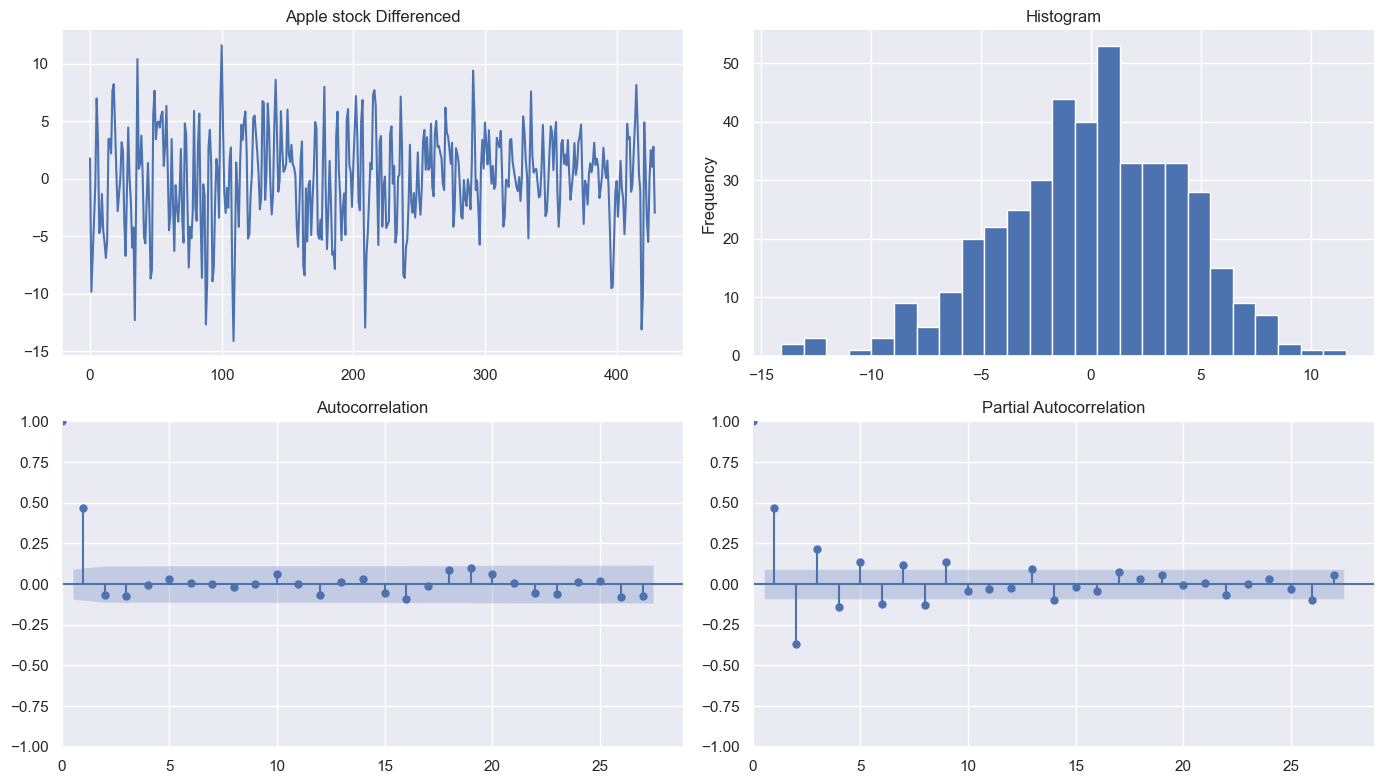

In [12]:
AAPLStockDiff = difference(AAPLStock['Open'], 2)
tsplot(AAPLStockDiff, title='Apple stock Differenced') 
plt.show()

In [13]:
adf(AAPLStockDiff)

ADF Test Results: 
Test Statistic: -5.7261
p-value: 0.0000006764
Critical Values: 
	1%: -3.446
	5%: -2.869
	10%: -2.570


In [14]:
#Once stock is differenced now we will begin to fit the ARIMA model for Apple Stock prices 
AIC_BIC_HQIC(AAPLStock['High'])

AIC (1, 1)
BIC (1, 0)
HQIC (1, 0)


In [15]:
#Fit model 
model = ARIMA(AAPLStock['High'], order=(5, 1, 0))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   High   No. Observations:                  432
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1024.106
Date:                Sat, 01 Feb 2025   AIC                           2060.212
Time:                        22:39:44   BIC                           2084.609
Sample:                             0   HQIC                          2069.845
                                - 432                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0835      0.046      1.808      0.071      -0.007       0.174
ar.L2         -0.0409      0.051     -0.803      0.422      -0.141       0.059
ar.L3         -0.0016      0.050     -0.032      0.9

## MICROSOFT STOCK ANALYSIS W/ FINANCIAL DATA


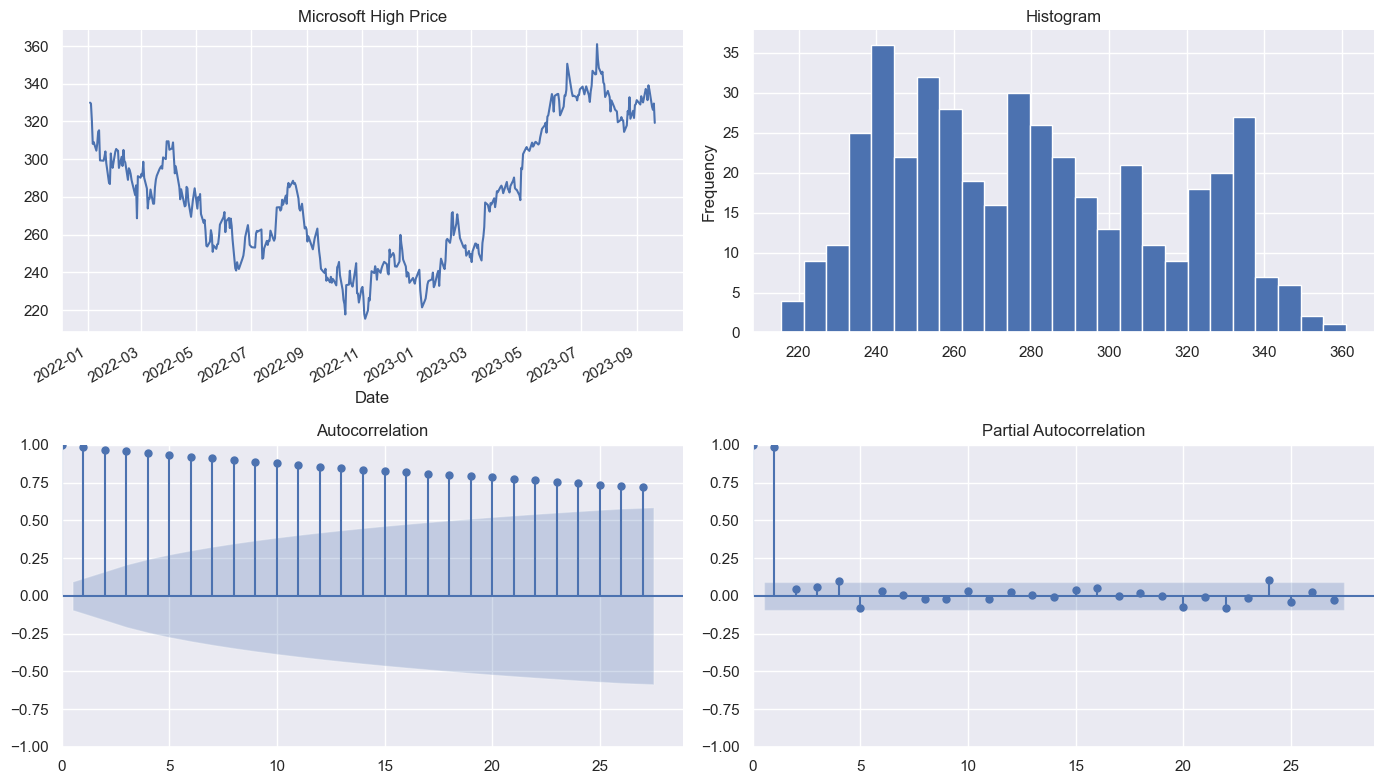

In [16]:
tsplot(MSFTStock['Open'], title='Microsoft High Price')
plt.show()

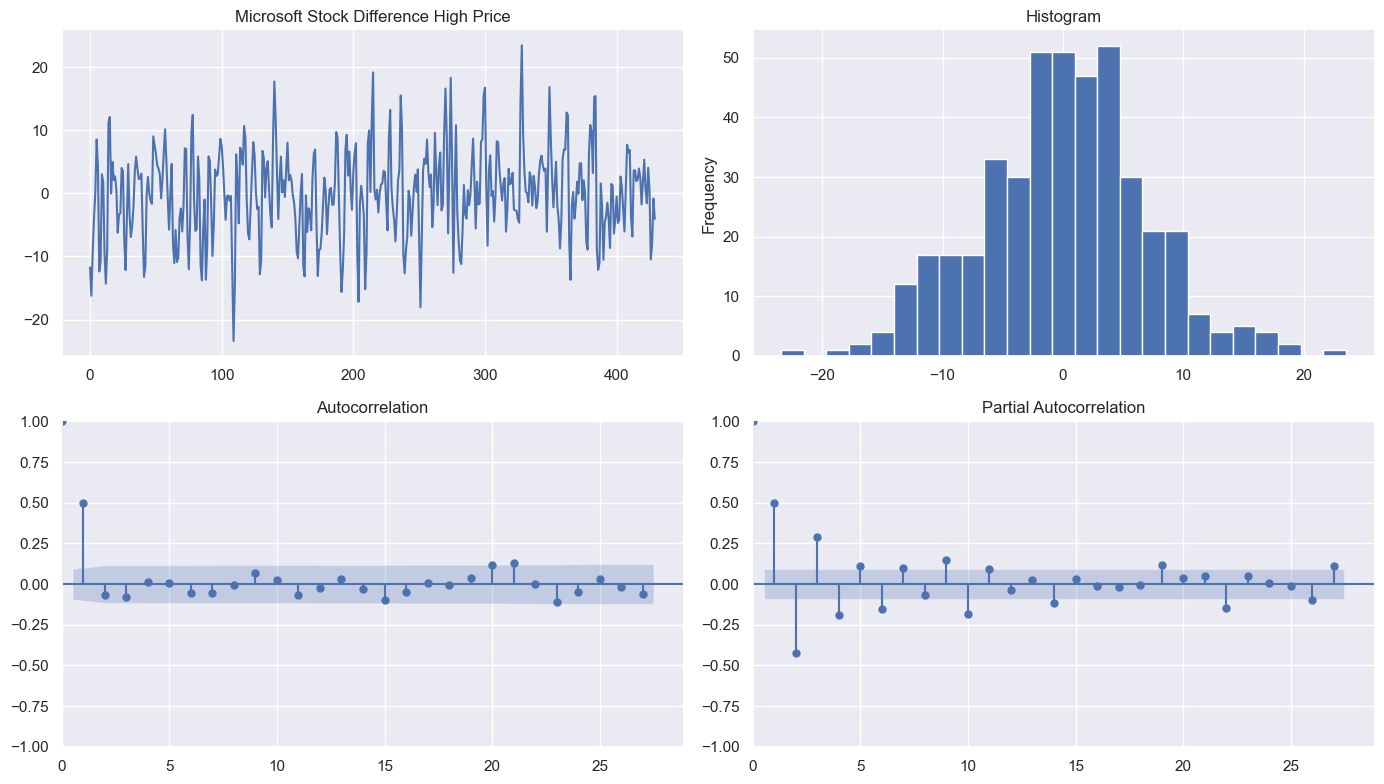

In [17]:
MSFTStockDiff = difference(MSFTStock['High'], 2)
tsplot(MSFTStockDiff, title = 'Microsoft Stock Difference High Price')
plt.show()

## DATA ANALYSIS
**Graph 1: Top Left**

**Graph 2: Top Right**

**Auto Correlation & PACF Comparison**
By examining the auto correlation of the microsoft stock, we can see that the acf is nearing 1 if not at 1 at times. This indicates a strong positive prediction that the stock price is valued and any current stock holders should keep their stock. 

By comparing both graphs, (I will refer to Graph 1 before differencing as G1 & after G2) G1 acf shows a gradual decline and G1 PACF showing a sharp decrease indicates that our data is non-stationary. Once differencing is applied we can see that in the ACF G2 it shows a sharp decline and in the PACF graph it is a gradual decline. This means our data is now stationary, meaning, there are no trends or patterns in the data.

Both have been applied to Apple stock (AAPL) and Microsoft (MSFT). 

Once results have been shown to be accurate and fully functional the last stock Amazon will be used to fully complete analysation of all 3 stocks 

In [18]:
print("MICROSOFT STOCK DATASET STATS")
adf(MSFTStockDiff)

MICROSOFT STOCK DATASET STATS
ADF Test Results: 
Test Statistic: -6.3192
p-value: 0.0000000310
Critical Values: 
	1%: -3.446
	5%: -2.869
	10%: -2.570


## P-VALUE STAT
Looking at the satatistics above we notice that the P-Value is 0. This mean that the null hypothises is true. P(E) = 0 if and only if event E is impossible. 

Due to the Test statistics being less than all critical values we can reject the null hypothises and conclude the difference series is stationary. This will apply to Apple and Amazon stock 

In [19]:
AIC_BIC_HQIC(MSFTStock['High'])

AIC (4, 3)
BIC (1, 0)
HQIC (1, 0)


**Fitting the ARIMA Model**
We will now begin to fit our model using the ARIMA (5, 1, 0)

- 5 lag steps for auto-regression (AR)
- 1st order differencing (I)
- No moving average term (MA)

                               SARIMAX Results                                
Dep. Variable:                   High   No. Observations:                  432
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1274.165
Date:                Sat, 01 Feb 2025   AIC                           2560.330
Time:                        22:40:08   BIC                           2584.727
Sample:                             0   HQIC                          2569.963
                                - 432                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0883      0.051      1.747      0.081      -0.011       0.187
ar.L2         -0.0792      0.052     -1.534      0.125      -0.181       0.022
ar.L3         -0.0571      0.049     -1.177      0.2

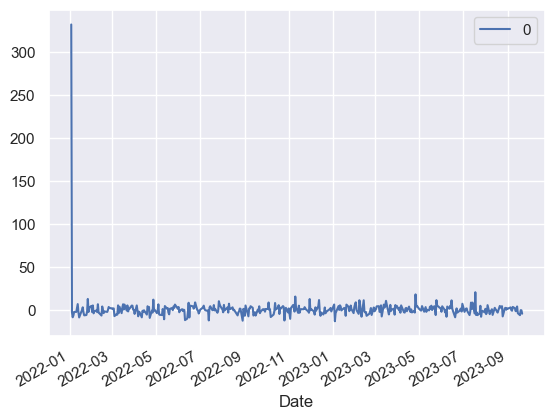

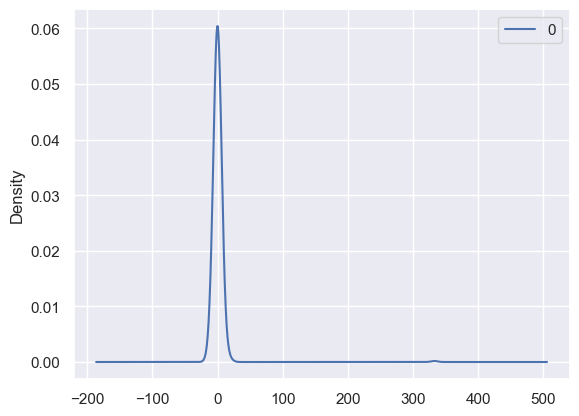

                0
count  432.000000
mean     0.752214
std     16.665300
min    -13.366990
25%     -2.920826
50%     -0.051772
75%      2.757648
max    332.592875


In [20]:
# fit model
model = ARIMA(MSFTStock['High'], order=(5,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

**How to forecast using ARIMA Model** 
Using a method called Rolling Forecast, this method will be used to forecast our future predictions. 
In a rolling forecast, the model is often retrained as new data becomes available allowing for more accurate and adaptive predictions 

**How to forecast with ARIMA** 

1. Use Predict() function on ARIMAResults object. This function will require the index of the time stepos for which predictions are needed
2. Revert any differencing and return predictions in the original scale, set the type argument to "levels"
3. Employ the forecast() function for simplier one-step forcasting. 

predicted=254.614984, expected=253.249030
predicted=253.742016, expected=255.738298
predicted=256.112470, expected=249.923349
predicted=248.555128, expected=251.735554
predicted=252.419394, expected=250.411256
predicted=250.430471, expected=249.853653
predicted=249.594024, expected=250.321632
predicted=250.513277, expected=254.523517
predicted=255.007787, expected=259.004233
predicted=259.050580, expected=256.584654
predicted=255.534233, expected=253.448164
predicted=253.292744, expected=258.446636
predicted=259.892389, expected=251.705663
predicted=250.349433, expected=256.803716
predicted=257.726554, expected=259.950184
predicted=260.243846, expected=265.336970
predicted=265.094744, expected=275.373700
predicted=276.004151, expected=282.114649
predicted=281.985765, expected=276.289767
predicted=274.530548, expected=273.820389
predicted=274.257129, expected=279.834507
predicted=281.603932, expected=279.854404
predicted=279.072988, expected=279.426256
predicted=278.950348, expected=280

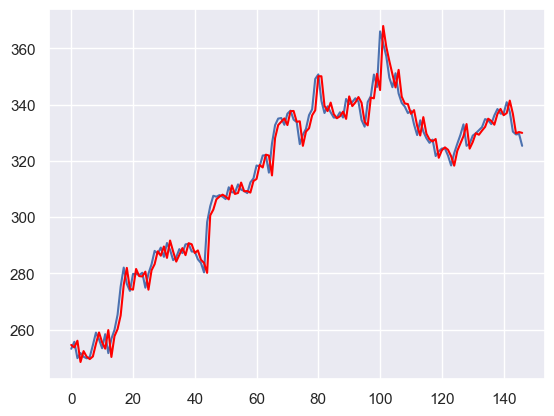

In [21]:
#split into train and test sets
X = MSFTStock['High'].values 
size = (int(len(X) * 0.66))
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# Walk-forward validation 
for t in range(len(test)): 
    model = ARIMA(history, order=(5, 1, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

#evaluate forecasts 
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes 
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()